# Comparative Analysis
In this notebook, we compare ClaP with state detection competitors.

In [77]:
%load_ext autoreload
%autoreload 2
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

from aeon.visualisation import plot_critical_difference
from external.MCM import MCM
from wand.image import Image

sns.set_theme()
sns.set_color_codes()

import os
import sys

sys.path.append("../../")

Let's choose a score for evaluation (F1, Covering, or AMI).

In [79]:
eval_score = "ami_score"

Let's load the scores from the different methods.

In [80]:
candidates = ["CLaP", "ClaSP2Feat", "TICC", "E2USD", "Time2State", "AutoPlait", "HDP-HSMM"]    
datasets = ["TSSB", "UTSA", "HAS", "SKAB", "MIT-BIH"] 

methods, dfs = list(), list()

'''
for d in datasets:
   if d == "TSSB":
       ds = load_tssb_datasets()
   elif d == "HAS":
       ds = load_has_datasets()
   else:
       ds = load_datasets(d)

   dataset_dfs[d] = ds
'''

for candidate_name in candidates:
    methods.append((candidate_name, f"{candidate_name}.csv.gz"))

for idx, (name, file_name) in enumerate(methods):
    df = []

    for d in datasets:
        scores = pd.read_csv(f"../../experiments/state_detection/{d}_{file_name}", usecols=["dataset", eval_score, "true_cps"],
                             compression="gzip")

        # filter data
        # ds = dataset_dfs[d]
        # assert np.array_equal(scores.dataset.to_numpy(), ds.dataset.to_numpy())
        # scores = scores[ds.labels.apply(lambda l: len(np.unique(l))) > 2]

        df.append(scores)

    df = pd.concat(df)
    df.sort_values(by="dataset", inplace=True)
    dfs.append((name, df))

df_scores = pd.DataFrame()

for name, df in dfs:
    df_scores["dataset"] = df.dataset
    df_scores[name] = df[eval_score]

df_scores.reset_index(drop=True, inplace=True)
df_scores

,dataset,CLaP,ClaSP2Feat,TICC,E2USD,Time2State,AutoPlait,HDP-HSMM
0,Adiac,0.944,0.854,0.000,0.144,0.069,0.000,0.307
1,ArrowHead,0.945,0.000,0.024,0.529,0.454,0.000,0.003
2,Beef,0.910,0.000,0.027,0.468,0.461,0.060,0.016
3,BeetleFly,0.915,0.000,0.014,0.467,0.459,0.000,0.004
4,BirdChicken,0.973,0.000,0.014,0.234,0.429,0.000,0.011
5,CBF,0.951,0.951,0.058,0.000,0.566,0.000,0.555
6,Cane,0.697,0.482,0.002,0.411,0.306,0.000,0.095
7,Car,0.796,0.000,0.050,0.289,0.460,0.000,0.127
8,Chinatown,1.000,1.000,1.000,1.000,1.000,1.000,1.000
9,ChlorineConcentration,0.000,0.000,0.003,0.014,0.097,0.000,0.008


Let's calculate the mean/median/std score.

In [81]:
df_scores.iloc[:, 1:].mean(axis=0).round(3).sort_values(ascending=False)

CLaP          0.604
Time2State    0.443
ClaSP2Feat    0.441
E2USD         0.420
HDP-HSMM      0.415
TICC          0.244
AutoPlait     0.175
dtype: float64

In [82]:
df_scores.iloc[:, 1:].median(axis=0).round(3).sort_values(ascending=False)

CLaP          0.670
Time2State    0.463
E2USD         0.454
ClaSP2Feat    0.439
HDP-HSMM      0.439
TICC          0.031
AutoPlait     0.000
dtype: float64

In [83]:
df_scores.iloc[:, 1:].std(axis=0).round(3).sort_values()

Time2State    0.233
E2USD         0.273
HDP-HSMM      0.279
CLaP          0.309
AutoPlait     0.329
ClaSP2Feat    0.344
TICC          0.348
dtype: float64

Let's compute the wins per method.

In [84]:
ranks = df_scores.iloc[:, 1:].rank(1, method='min', ascending=False)
means = np.array(ranks.mean(axis=0))
args = np.argsort(means)

In [85]:
for mean, name in zip(means[args], df_scores.columns[1:].to_numpy()[args]):
    print(f"{name}:wins={ranks[ranks[name] == 1].shape[0]} rank={np.round(mean, 1)}")

CLaP:wins=193 rank=2.3
Time2State:wins=32 rank=3.4
E2USD:wins=44 rank=3.5
HDP-HSMM:wins=70 rank=3.5
ClaSP2Feat:wins=94 rank=3.6
TICC:wins=62 rank=4.7
AutoPlait:wins=45 rank=5.5


Let's plot the CD diagram.

/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_4653/3956203820.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"../../figures/cd_state_detection_comparative_{eval_score}.pdf", bbox_inches="tight")
/Users/ermshaua/miniconda3/envs/clap/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


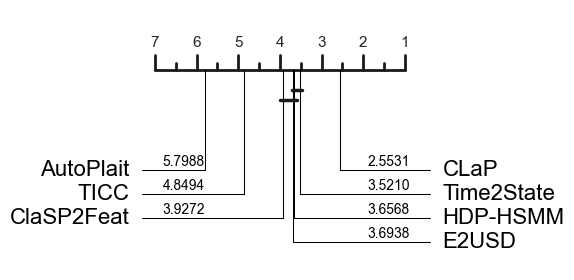

In [86]:
ax = plot_critical_difference(
    scores=df_scores.iloc[:, 1:].to_numpy(),
    labels=df_scores.columns[1:].to_numpy(),
    alpha=0.05,
    width=5,
    textspace=1.5,
)

plt.savefig(f"../../figures/cd_state_detection_comparative_{eval_score}.pdf", bbox_inches="tight")

 Let's plot the MCM.

Processing HDP-HSMM, AutoPlait:   0%|          | 0/7 [00:00<?, ?it/s]   


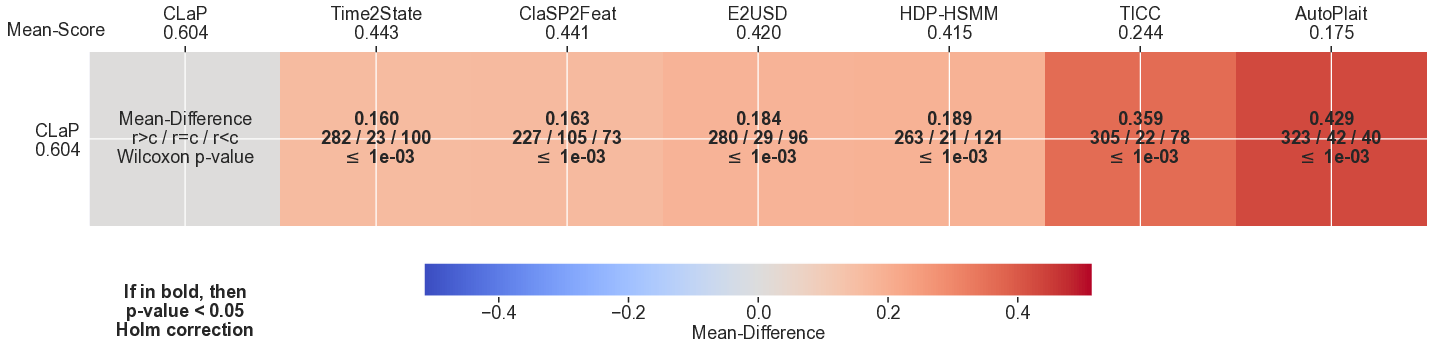

In [87]:
dir_path = "../../figures/"
file_name = f"mcm_state_detection_comparative_{eval_score}"

MCM.compare(
    output_dir=dir_path,
    used_statistic="Score",
    save_as_json=False,
    df_results=df_scores.iloc[:, 1:],
    pdf_savename=file_name,
    load_analysis=False,
    pvalue_correction="Holm",
    row_comparates=("CLaP",),
    fig_size=(20, 5),
    font_size=18,
    precision=3
)
Image(filename=os.path.join(dir_path, file_name + ".pdf"))

Let's compute wins/losses against ClaSP.

In [88]:
selection = "CLaP"

for rival in df_scores.columns[1:]:
    if rival == selection: continue

    df_pair = df_scores[[selection, rival]]
    pair_ranks = df_pair.rank(1, method='min', ascending=False)

    wins = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 2)].shape[0]
    losses = pair_ranks[(pair_ranks[selection] == 2) & (pair_ranks[rival] == 1)].shape[0]
    ties = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 1)].shape[0]

    assert wins + losses + ties == pair_ranks.shape[0]

    print(f"{selection} vs {rival}: (wins/ties/losses): {wins}/{ties}/{losses}")

CLaP vs ClaSP2Feat: (wins/ties/losses): 227/105/73
CLaP vs TICC: (wins/ties/losses): 305/22/78
CLaP vs E2USD: (wins/ties/losses): 280/29/96
CLaP vs Time2State: (wins/ties/losses): 282/23/100
CLaP vs AutoPlait: (wins/ties/losses): 323/42/40
CLaP vs HDP-HSMM: (wins/ties/losses): 263/21/121


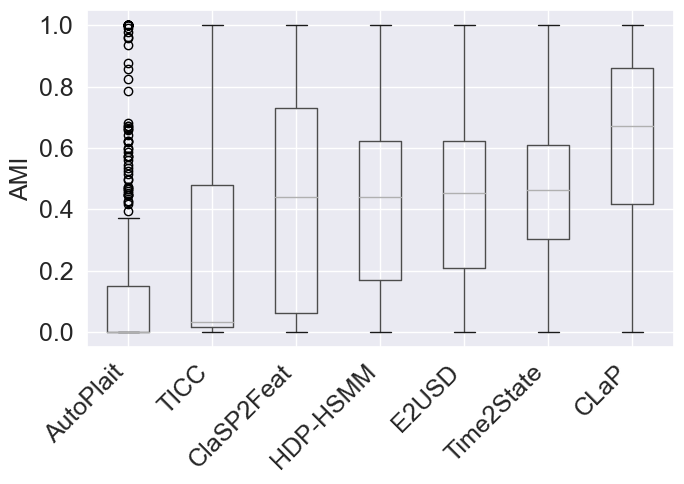

In [89]:
fontsize = 18
_, ax = plt.subplots(figsize=(7, 5))

# Sort by median performance
df_sorted_scores = df_scores[df_scores.iloc[:, 1:].median(axis=0).sort_values().index]

if eval_score == "covering_score":
    score_name = "Covering"
elif eval_score == "ami_score":
    score_name = "AMI"
else:
    assert False, "Unknown score."

df_sorted_scores.boxplot(ax=ax, rot=90)
ax.set_ylabel(score_name, fontsize=fontsize)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xticklabels(df_sorted_scores.columns, rotation=45, ha="right")
ax.set_yticks(np.round(np.arange(0, 1.0 + .2, .2), 1))

plt.savefig(f"../../figures/bp_state_detection_comparative_{eval_score}.pdf", bbox_inches="tight")